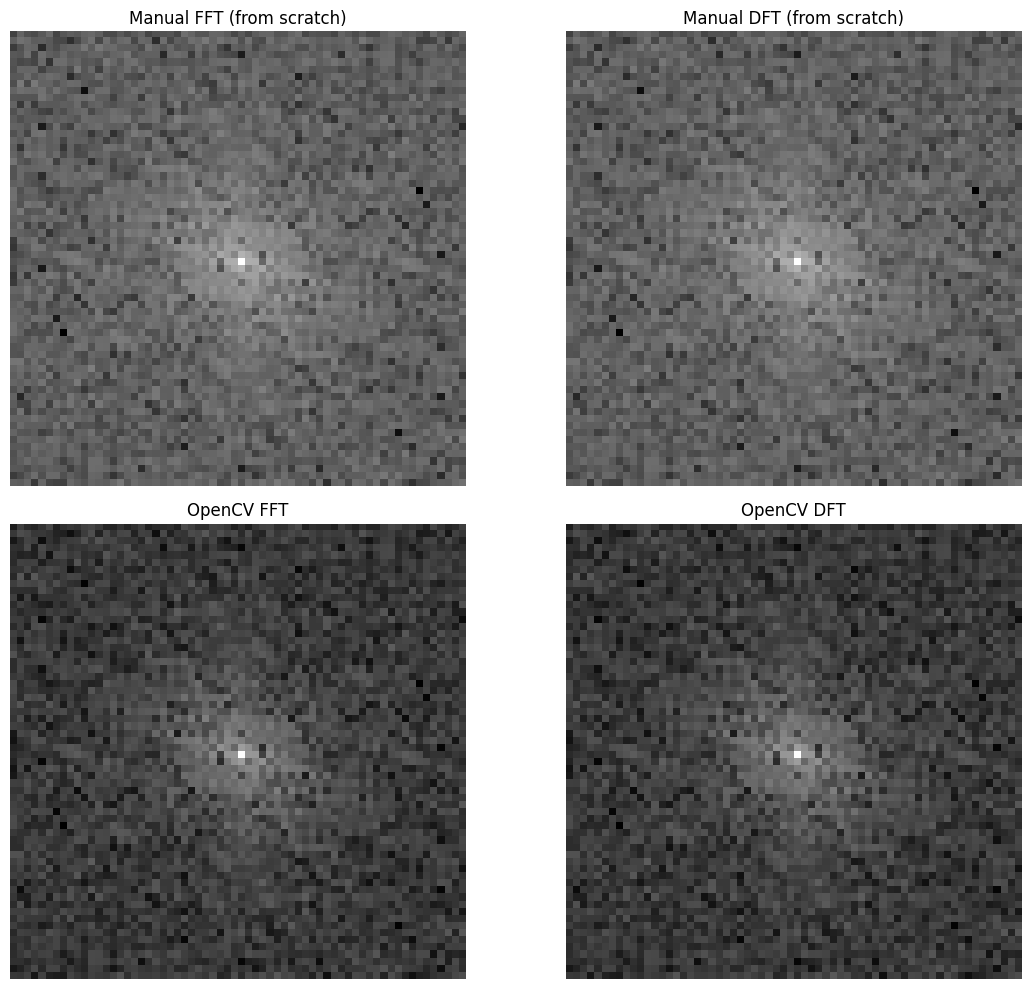

In [17]:
import cv2
import math
import cmath
import matplotlib.pyplot as plt
import numpy as np

# -------------------------------
# 1D FFT IMPLEMENTATION
# -------------------------------
def fft1d(x):
    """
    Compute 1D FFT of a list x manually using Cooley-Tukey algorithm.
    Length of x must be a power of 2.
    """
    N = len(x)
    if N <= 1:
        return x
    even = fft1d(x[0::2])
    odd = fft1d(x[1::2])
    combined = [0] * N
    for k in range(N // 2):
        t = cmath.exp(-2j * math.pi * k / N) * odd[k]
        combined[k] = even[k] + t
        combined[k + N//2] = even[k] - t
    return combined

# -------------------------------
# Manual 2D FFT
# -------------------------------
def manual_fft(image):
    rows = len(image)
    cols = len(image[0])

    # Pad to next power of 2
    def next_power_of_2(n):
        p = 1
        while p < n:
            p *= 2
        return p

    rows_p = next_power_of_2(rows)
    cols_p = next_power_of_2(cols)

    # Pad image
    padded = [[0]*cols_p for _ in range(rows_p)]
    for r in range(rows):
        for c in range(cols):
            padded[r][c] = image[r][c]

    # FFT on rows
    row_fft = [fft1d(r) for r in padded]

    # FFT on columns
    col_fft = []
    for c in range(cols_p):
        col = [row_fft[r][c] for r in range(rows_p)]
        fft_col = fft1d(col)
        col_fft.append(fft_col)

    # Transpose to get final 2D FFT
    fft2d_result = [[col_fft[c][r] for c in range(cols_p)] for r in range(rows_p)]

    # Compute magnitude spectrum
    magnitude = [[20 * math.log(abs(fft2d_result[r][c]) + 1) for c in range(cols)] for r in range(rows)]

    # Center the spectrum
    magnitude = fftshift2d(magnitude)
    return magnitude

# -------------------------------
# Manual 2D DFT
# -------------------------------
def manual_dft(image):
    M = len(image)
    N = len(image[0])
    dft = [[0]*N for _ in range(M)]

    for u in range(M):
        for v in range(N):
            sum_val = 0
            for x in range(M):
                for y in range(N):
                    angle = -2 * math.pi * ((u * x)/M + (v * y)/N)
                    sum_val += image[x][y] * complex(math.cos(angle), math.sin(angle))
            dft[u][v] = sum_val

    magnitude = [[20 * math.log(abs(dft[r][c]) + 1) for c in range(N)] for r in range(M)]

    # Center the spectrum
    magnitude = fftshift2d(magnitude)
    return magnitude

# -------------------------------
# Manual fftshift
# -------------------------------
def fftshift2d(magnitude):
    rows = len(magnitude)
    cols = len(magnitude[0])
    shifted = [[0]*cols for _ in range(rows)]
    r2 = rows // 2
    c2 = cols // 2
    for r in range(rows):
        for c in range(cols):
            shifted[r][c] = magnitude[(r + r2) % rows][(c + c2) % cols]
    return shifted

# -------------------------------
# OpenCV FFT using cv2.dft
# -------------------------------
def cv2_fft(image):
    img_float = cv2.normalize(image.astype('float32'), None, 0.0, 1.0, cv2.NORM_MINMAX)
    dft = cv2.dft(img_float, flags=cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)
    magnitude = cv2.magnitude(dft_shift[:,:,0], dft_shift[:,:,1])
    magnitude_spectrum = 20 * np.log(magnitude + 1)
    return magnitude_spectrum

# OpenCV DFT (same as FFT here)
def cv2_dft(image):
    return cv2_fft(image)

# -------------------------------
# MAIN EXECUTION
# -------------------------------
if __name__ == "__main__":
    # Load grayscale image
    img = cv2.imread(cv2.samples.findFile('../images/img7.png'), cv2.IMREAD_GRAYSCALE)
    if img is None:
        # fallback random image
        img = np.random.randint(0, 256, (64, 64), dtype=np.uint8)

    # Resize for manual FFT/DFT
    img_small = cv2.resize(img, (64, 64))
    img_list = img_small.tolist()  # convert to 2D list for manual methods

    # Apply manual methods
    fft_manual = manual_fft(img_list)
    dft_manual = manual_dft(img_list)

    # Apply OpenCV built-in methods
    fft_cv2 = cv2_fft(img_small)
    dft_cv2 = cv2_dft(img_small)

    # Plot all 4 results
    plt.figure(figsize=(12, 10))

    plt.subplot(2, 2, 1)
    plt.imshow(fft_manual, cmap='gray')
    plt.title("Manual FFT (from scratch)")
    plt.axis('off')

    plt.subplot(2, 2, 2)
    plt.imshow(dft_manual, cmap='gray')
    plt.title("Manual DFT (from scratch)")
    plt.axis('off')

    plt.subplot(2, 2, 3)
    plt.imshow(fft_cv2, cmap='gray')
    plt.title("OpenCV FFT")
    plt.axis('off')

    plt.subplot(2, 2, 4)
    plt.imshow(dft_cv2, cmap='gray')
    plt.title("OpenCV DFT")
    plt.axis('off')

    plt.tight_layout()
    plt.savefig('fft_dft_results.png')
    # plt.show()
